In [23]:
import pandas as pd
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LeakyReLU, Input, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1_l2
#from keras.backend import clear_session
from livelossplot import PlotLossesKeras
from dateutil import parser
import dateutil.parser

from glob import glob
from os.path import join

from scipy.stats import zscore
from functools import reduce

In [2]:
weather_path = join('..','data','weather','precip_temp.csv')
weather_df = pd.read_csv(weather_path)
clients_path = join('..','data','wifi','**','Clients per day.csv')
clients_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(clients_path),reverse=True)), ignore_index=True)
sessions_path = join('..','data','wifi','**','Number of sessions over time.csv')
sessions_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(sessions_path), reverse=True)), ignore_index=True)

# Interpolate zeros in usage data
sessions_df.loc[sessions_df['# Sessions'] == 0, '# Sessions'] = np.NaN
sessions_df['# Sessions'] = sessions_df['# Sessions'].interpolate()

In [54]:
# Add day of the week as a one-hot
weekday_labels = []
for d in range(7):
    label = 'weekday-%i' % d
    weekday_labels.append(label)
    clients_df[label] = [int(dt.weekday()==d) for dt in clients_df['Time']]
    
# Put wifi date in the same format as it is in the weather data
clients_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in clients_df['Time']]
clients_df['Year %'] = [dt.timetuple()[7] / 365 for dt in clients_df['Time']]
sessions_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in sessions_df['Time']]

all_data = clients_df.merge(weather_df, left_on='Date', right_on='DATE') \
    .merge(sessions_df, left_on='Date', right_on='Date')

# Normalize weather data
all_data[['TMIN','TMAX']] -= (all_data[['TMIN', 'TMAX']].sum().sum() \
                              / all_data[['TMIN', 'TMAX']].size)
all_data[['TMIN','TMAX']] /= (all_data[['TMIN', 'TMAX']].abs().sum().sum() \
                              / all_data[['TMIN', 'TMAX']].size)
all_data['PRCP'] = zscore(all_data['PRCP'])

In [5]:
# Shuffle data
all_data = all_data.sample(frac=1)

# Separate inputs into categories for encoding
weather_x = all_data[['PRCP', 'TMAX', 'TMIN']].values
day_x = all_data[weekday_labels].values
date_x = all_data[['Year %']]

clients_y = all_data[['# Clients']].values
sessions_y = all_data[['# Sessions']].values

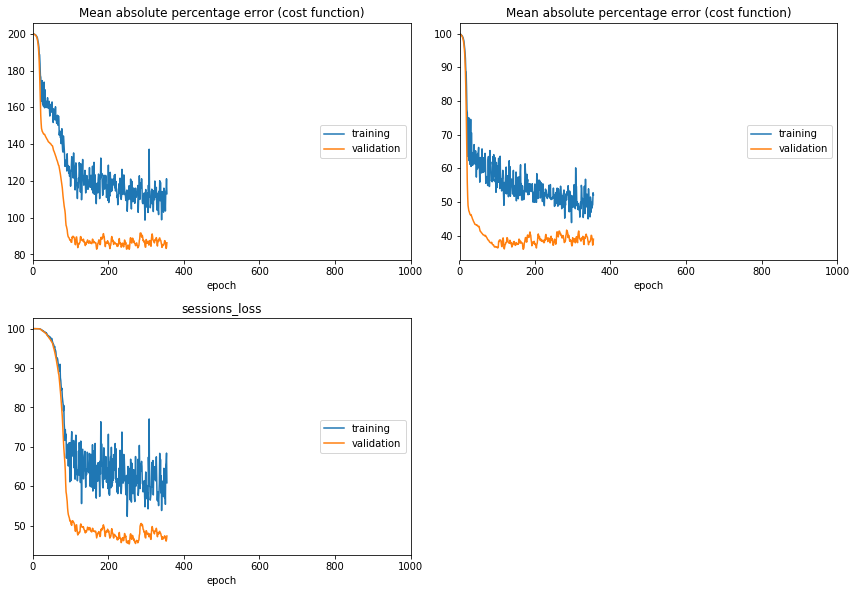

Epoch 00355: early stopping


In [6]:
clear_session()

epochs = 1000
reg = None

stack_layers = lambda layers: reduce(lambda stack, e: e(stack), layers)

weather_layers = \
  [Input((3,), name='weather')] \
+ [Dropout(0.2)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)]

weather_out = stack_layers(weather_layers)

day_layers = \
  [Input((7,), name='day')] \
+ [Dense(15, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(25, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(12, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)]

day_out = stack_layers(day_layers)

date_layers = \
  [Input((1,), name='date')] \
+ [Dropout(0.2)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(15, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)]

date_out = stack_layers(date_layers)

main_layers = \
  [concatenate([weather_out, day_out, date_out])] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(100, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(100, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.3)] 

main_out = stack_layers(main_layers)

clients_layers = \
  [main_out] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(1, activation='relu',kernel_regularizer=reg, name='clients')]

clients_out = stack_layers(clients_layers)

sessions_layers = \
  [main_out] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.2)] \
+ [Dense(1, activation='relu',kernel_regularizer=reg, name='sessions')]

sessions_out = stack_layers(sessions_layers)

model = Model(inputs=[weather_layers[0], day_layers[0], date_layers[0]],
              outputs=[clients_out, sessions_out])
model.compile(loss='mean_absolute_percentage_error',
              optimizer=Adam(0.0001))

model.summary()

early_stopping = EarlyStopping(patience=100, verbose=1)
history = model.fit(x=[weather_x,day_x,date_x], y=[clients_y,sessions_y],
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.08,
                    callbacks=[early_stopping, PlotLossesKeras()],
                    batch_size=32)
model_path = join('..','models','model.h5')
model.save(model_path)


In [13]:
print(np.std(model.predict([weather_x,day_x,date_x]), axis=1))
print(np.std(clients_y))
print(np.std(sessions_y))

[[ 21.372765]
 [162.21115 ]]
54.125903955150655
520.2027223633681
